In [2]:
from mantid.simpleapi import *
from mantid.api import MatrixWorkspace
from mantid.api import AnalysisDataService as ADS
from mantid.api import *
from mantid.kernel import *
from sansdata import *

FrameworkManager-[Notice] Welcome to Mantid 6.10.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.10
DownloadInstrument-[Notice] All instrument definitions up to date


## 1. Create `Workspace` from data and instrument definition

Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
Sample: memb_BS_Q1_6_0Ang
275:750, 50:974
self.intensity shape: (924, 475)
lambda_0: 5.997383326898995


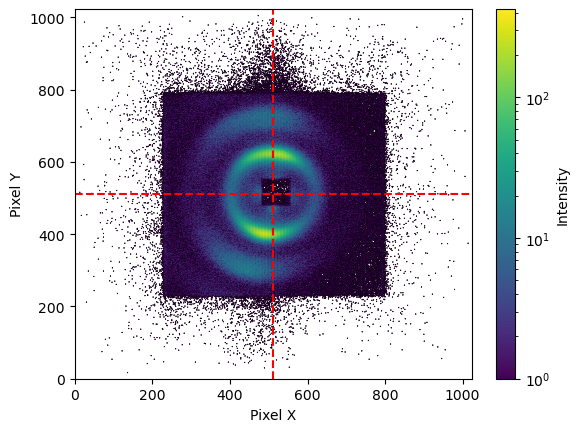

In [3]:
sans_file = SansData("data/memb_BS_Q1_6_0Ang.mpa")
# sans_file = SansData("data/Cnano_BS_Q1_6_0Ang.mpa")
sans_file.plot_2d()

In [5]:
nBins = 1

delta_L_over_L0 = 0.1
bin_lower = sans_file.L0 * (1.0 - delta_L_over_L0/2)
bin_upper = sans_file.L0 * (1.0 + delta_L_over_L0/2)

detectors = 1024 * 1024

# Use the same bin for each
x = np.tile([bin_lower,bin_upper],detectors)
y = sans_file.raw_intensity

ws = CreateWorkspace(OutputWorkspace = "raw_2D_counts",UnitX="Wavelength",DataX=x, DataY=y, NSpec=detectors)
mon = LoadInstrument(ws, FileName="RIDSANS_Definition.xml", RewriteSpectraMap=True)
MoveInstrumentComponent(ws, ComponentName="sample-position", X=0.0, Y=0.0, Z=-sans_file.d, RelativePosition = False)


CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 1.16 seconds
LoadInstrument-[Notice] LoadInstrument started
LoadInstrument-[Notice] LoadInstrument successful, Duration 2.51 seconds
MoveInstrumentComponent-[Notice] MoveInstrumentComponent started
MoveInstrumentComponent-[Notice] MoveInstrumentComponent successful, Duration 0.00 seconds



## 2. Verify basic Workspace properties

In [6]:
# Print some basic instrument and workspace information
inst = ws.getInstrument()
si = ws.spectrumInfo()
di = ws.detectorInfo()
ci = ws.componentInfo()
print("Workspace {0} has instrument: {1}".format(ws.name(), inst.getName()))
print("Instrument {0} has {1} components, including {2} monitors and {3} detectors".format(inst.getName(), ci.size(), len(mon), di.size()))


unit = ws.getAxis(0).getUnit().unitID()
unit2 = ws.getAxis(1).getUnit().unitID()
print(unit)
print(unit2)

# Get the sample position
instrument = ws.getInstrument()

sample = instrument.getSample()
sample_position_1 = sample.getPos()

# sample_position_2 = si.samplePosition()

# print(spectrum_info, detector_info)
print("Sample Position:", sample_position_1)
# print("Sample Position:", sample_position_2)

num_spec = ws.getNumberHistograms()
num_bins = ws.blocksize()
print("Detector spectrum blocksize:", num_bins)
print("Number of spectra:", num_spec)
for i in range(num_spec):
    # Check that all spectra have a matching detector
    assert(si.hasDetectors(i))
    # Assert that at this point no spectrum is masked
    assert(not si.isMasked(i))
    # print(si.position(i))

Workspace raw_2D_counts has instrument: RIDSANS
Instrument RIDSANS has 1049604 components, including 0 monitors and 1048576 detectors
Wavelength
Label
Sample Position: [0,0,-11.0623]
Detector spectrum blocksize: 1
Number of spectra: 1048576


The following code probes the histograms of a cross section of the detectors, looking for detectors with a particularly high count. It also verifies that the bin (X-axis) is correct.

In [15]:
# print("number of histograms = {0}".format(ws.getNumberHistograms()))
# # ws.getSpectrum(3)
# for i in range(0,ws.getNumberHistograms(),100):
#     sum_counts = ws.readY(i)[0]

#     # Display spectrum number against sum_counts
#     if sum_counts >= 100.0:
#         print("{0} {1} {2}".format(ws.getSpectrum(i).getSpectrumNo(), sum_counts,ws.readX(i)))

## 2.1. Mask detectors outside of active region


In [7]:
active_w = 0.15 # m
active_h = 0.15 # m
half_w = active_w/2
half_h = active_h/2

def mask_rectangle(ws, w, h, negative=False, offset_x = 0, offset_y=0):
    # Gets large for a 1024 x 1024 detector but at most ~30 MB
    mask_list = []
    for i in range(ws.getNumberHistograms()):
        detector = ws.getDetector(i)
        # Get the position of the detector
        position = detector.getPos()
        if (abs(position.getX() - offset_x) > w/2 or abs(position.getY() - offset_y) > h/2) == (not negative): 
            mask_list.append(i+1)
    MaskDetectors(Workspace=ws, SpectraList=mask_list)

mask_rectangle(ws, active_w, active_h)
mask_rectangle(ws, sans_file.beamstop.w, sans_file.beamstop.h, offset_x = sans_file.beamstop.x, offset_y=sans_file.beamstop.y, negative=True)
# # Calling MaskDetectors
# mask_list = []
# for i in range(ws.getNumberHistograms()):
#     detector = ws.getDetector(i)
#     # Get the position of the detector
#     position = detector.getPos()
#     if abs(position.getX()) > half_w or abs(position.getY()) > half_h: 
#         mask_list.append(i+1)

# MaskDetectors(Workspace=ws, SpectraList=mask_list)
print("Completed masking")

MaskDetectors-[Notice] MaskDetectors started
MaskDetectors-[Notice] MaskDetectors successful, Duration 0.51 seconds
MaskDetectors-[Notice] MaskDetectors started
Completed masking
MaskDetectors-[Notice] MaskDetectors successful, Duration 0.01 seconds


## 2.2. Calculate $Q_{max}$ and run `Qxy` algorithm

In [8]:
max_det_x = 0.140662
max_det_y = 0.140662
ds_dist = sans_file.d
r = np.sqrt(2) * max_det_x
Q_max = 4 * np.pi / sans_file.L0 * np.sin(np.arctan(r/(ds_dist)) / 2)
Q_max # AA-1

0.018835152278343776

In [9]:
delta_Q = 0.0001
max_QXY = 0.01
N_Q_bins = int(np.ceil(2*max_QXY/delta_Q))

# ws_scaled = ws / 1000
Qxy(ws,SolidAngleWeighting=True,MaxQxy=max_QXY, DeltaQ=delta_Q,OutputWorkspace="new")
reduced_ws = ADS.retrieve('new')
# dir(reduced_ws)

Q_array = np.zeros((N_Q_bins, N_Q_bins))
# Q_axis = np.zeros((N_Q_bins))
Q_axis = np.array(reduced_ws.dataX(0))
for i in range(N_Q_bins):
    Q_array[i] = reduced_ws.dataY(i)
Q_axis, Q_array

Qxy-[Notice] Qxy started
Qxy-[Notice] There are a total of 259 (0%) empty Q bins.
Qxy-[Notice] Qxy successful, Duration 0.79 seconds


(array([-1.0e-02, -9.9e-03, -9.8e-03, -9.7e-03, -9.6e-03, -9.5e-03,
        -9.4e-03, -9.3e-03, -9.2e-03, -9.1e-03, -9.0e-03, -8.9e-03,
        -8.8e-03, -8.7e-03, -8.6e-03, -8.5e-03, -8.4e-03, -8.3e-03,
        -8.2e-03, -8.1e-03, -8.0e-03, -7.9e-03, -7.8e-03, -7.7e-03,
        -7.6e-03, -7.5e-03, -7.4e-03, -7.3e-03, -7.2e-03, -7.1e-03,
        -7.0e-03, -6.9e-03, -6.8e-03, -6.7e-03, -6.6e-03, -6.5e-03,
        -6.4e-03, -6.3e-03, -6.2e-03, -6.1e-03, -6.0e-03, -5.9e-03,
        -5.8e-03, -5.7e-03, -5.6e-03, -5.5e-03, -5.4e-03, -5.3e-03,
        -5.2e-03, -5.1e-03, -5.0e-03, -4.9e-03, -4.8e-03, -4.7e-03,
        -4.6e-03, -4.5e-03, -4.4e-03, -4.3e-03, -4.2e-03, -4.1e-03,
        -4.0e-03, -3.9e-03, -3.8e-03, -3.7e-03, -3.6e-03, -3.5e-03,
        -3.4e-03, -3.3e-03, -3.2e-03, -3.1e-03, -3.0e-03, -2.9e-03,
        -2.8e-03, -2.7e-03, -2.6e-03, -2.5e-03, -2.4e-03, -2.3e-03,
        -2.2e-03, -2.1e-03, -2.0e-03, -1.9e-03, -1.8e-03, -1.7e-03,
        -1.6e-03, -1.5e-03, -1.4e-03, -1.3e-03, 

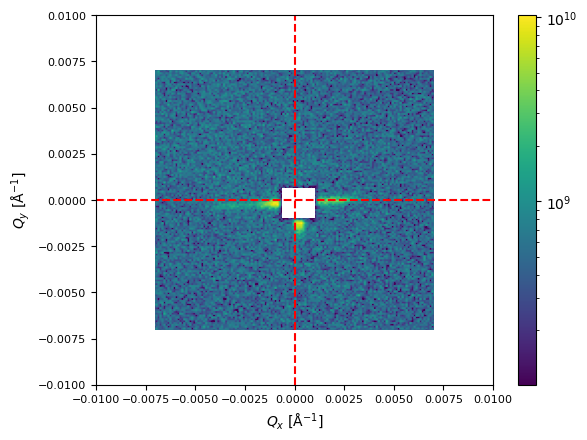

In [10]:
from matplotlib.colors import LogNorm
# print(Q_array)
extent = [Q_axis[0], Q_axis[-1], Q_axis[0], Q_axis[-1]]
plt.imshow(Q_array, cmap='viridis', extent=extent, norm=LogNorm(),aspect='auto')  # cmap defines the color map (optional)
plt.colorbar()  # Add a colorbar to show the color scale
plt.xlabel(r'$Q_x$ [Å$^{-1}$]')
plt.ylabel(r'$Q_y$ [Å$^{-1}$]')
plt.xticks(fontsize=8)
plt.axvline(0, linestyle='--', color='red')
plt.axhline(0, linestyle='--', color='red')
plt.yticks(fontsize=8)
plt.show()